# ChatGPT Twitter Sentiment Analysis

Model: CNN (convolutional neural network)
Layers: 

In [39]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

In [40]:
# Load and preprocess the dataset
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def tokenize_data(text):
    return tokenizer(text)

data = pd.read_csv('data/tweets_with_splits_lite.csv')

le = LabelEncoder()
data['rating'] = le.fit_transform(data['rating'])

In [41]:
class TweetDataset(Dataset):
    def __init__(self, data, tokenizer, vocab, max_length=100):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet = self.data.iloc[idx]['tweet']
        tokenized_tweet = tokenize_data(tweet)
        numericalized_tweet = [vocab[token] for token in tokenized_tweet]

        # Pad the numericalized_tweet with <pad> tokens
        if len(numericalized_tweet) < self.max_length:
            numericalized_tweet += [vocab['<pad>']] * (self.max_length - len(numericalized_tweet))

        tweet_tensor = torch.tensor(numericalized_tweet[:self.max_length], dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx]['rating'], dtype=torch.float)
        return tweet_tensor, label


train_dataset = TweetDataset(data[data['split'] == 'train'], tokenize_data, vocab)
val_dataset = TweetDataset(data[data['split'] == 'val'], tokenize_data, vocab)
test_dataset = TweetDataset(data[data['split'] == 'test'], tokenize_data, vocab)

In [103]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenize_data(text)


vocab = build_vocab_from_iterator(yield_tokens(data['tweet']), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

text_pipeline = lambda x: vocab(tokenize_data(x))
label_pipeline = lambda x: int(x)

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, n_layers):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

    

In [93]:
input_dim = len(vocab)
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout,n_layers=0).to(device)

# Create DataLoaders
def collate_batch(batch):
    text_list, label_list = [], []
    for (_rating, _tweet) in batch:
        label_list.append(label_pipeline(_rating))
        processed_text = torch.tensor(text_pipeline(_tweet), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.nn.utils.rnn.pad_sequence(text_list, padding_value=0.0, batch_first=True), torch.tensor(label_list, dtype=torch.float32)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
epochs = 10
lr = 0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text, label = batch
        text, label = text.to(device), label.to(device)
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, label)
        acc = ((torch.sigmoid(predictions) > 0.5).float() == label).float().mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, label = batch
            text, label = text.to(device), label.to(device)
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label)
            acc = ((torch.sigmoid(predictions) > 0.5).float() == label).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

# Evaluate the model on the test set
test_loss, test_acc = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 01 | Train Loss: 0.566 | Train Acc: 70.20% | Val. Loss: 0.429 | Val. Acc: 81.44%
Epoch: 02 | Train Loss: 0.388 | Train Acc: 82.82% | Val. Loss: 0.346 | Val. Acc: 85.03%
Epoch: 03 | Train Loss: 0.274 | Train Acc: 89.03% | Val. Loss: 0.310 | Val. Acc: 87.44%
Epoch: 04 | Train Loss: 0.208 | Train Acc: 92.22% | Val. Loss: 0.291 | Val. Acc: 88.45%
Epoch: 05 | Train Loss: 0.145 | Train Acc: 94.80% | Val. Loss: 0.289 | Val. Acc: 88.81%
Epoch: 06 | Train Loss: 0.108 | Train Acc: 96.23% | Val. Loss: 0.297 | Val. Acc: 89.26%
Epoch: 07 | Train Loss: 0.077 | Train Acc: 97.45% | Val. Loss: 0.319 | Val. Acc: 89.53%
Epoch: 08 | Train Loss: 0.059 | Train Acc: 98.10% | Val. Loss: 0.346 | Val. Acc: 89.93%
Epoch: 09 | Train Loss: 0.051 | Train Acc: 98.42% | Val. Loss: 0.361 | Val. Acc: 89.46%
Epoch: 10 | Train Loss: 0.041 | Train Acc: 98.71% | Val. Loss: 0.378 | Val. Acc: 89.66%
Test Loss: 0.356 | Test Acc: 90.35%


In [86]:
from sklearn.metrics import classification_report
import pandas as pd

# Evaluate the model on the test set
test_loss, test_acc = evaluate(model, test_dataloader, criterion)

# Compute precision, recall, and F1-score for each class
model.eval()
with torch.no_grad():
    y_true, y_pred = [], []
    for batch in test_dataloader:
        text, label = batch
        text, label = text.to(device), label.to(device)
        predictions = model(text).squeeze(1)
        y_true.extend(label.cpu().numpy())
        y_pred.extend((torch.sigmoid(predictions) > 0.5).float().cpu().numpy())

# Get the classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a pandas DataFrame and print it
df = pd.DataFrame(report).transpose()
print(df)

              precision    recall  f1-score      support
0.0            0.896346  0.899333  0.897837  1500.000000
1.0            0.898997  0.896000  0.897496  1500.000000
accuracy       0.897667  0.897667  0.897667     0.897667
macro avg      0.897671  0.897667  0.897666  3000.000000
weighted avg   0.897671  0.897667  0.897666  3000.000000


# Tuning The Parameters

## 1.dimension of the word embeddings

Epoch: 01 | Train Loss: 0.590 | Train Acc: 68.27% | Val. Loss: 0.475 | Val. Acc: 77.90%
Epoch: 02 | Train Loss: 0.429 | Train Acc: 80.40% | Val. Loss: 0.378 | Val. Acc: 83.57%
Epoch: 03 | Train Loss: 0.334 | Train Acc: 85.60% | Val. Loss: 0.340 | Val. Acc: 85.38%
Epoch: 04 | Train Loss: 0.259 | Train Acc: 90.07% | Val. Loss: 0.318 | Val. Acc: 86.71%
Epoch: 05 | Train Loss: 0.204 | Train Acc: 92.22% | Val. Loss: 0.302 | Val. Acc: 88.01%
Epoch: 06 | Train Loss: 0.158 | Train Acc: 94.14% | Val. Loss: 0.304 | Val. Acc: 87.92%
Epoch: 07 | Train Loss: 0.127 | Train Acc: 95.35% | Val. Loss: 0.314 | Val. Acc: 88.72%
Epoch: 08 | Train Loss: 0.099 | Train Acc: 96.50% | Val. Loss: 0.326 | Val. Acc: 89.28%
Epoch: 09 | Train Loss: 0.076 | Train Acc: 97.42% | Val. Loss: 0.329 | Val. Acc: 89.68%
Epoch: 10 | Train Loss: 0.061 | Train Acc: 97.89% | Val. Loss: 0.357 | Val. Acc: 89.75%


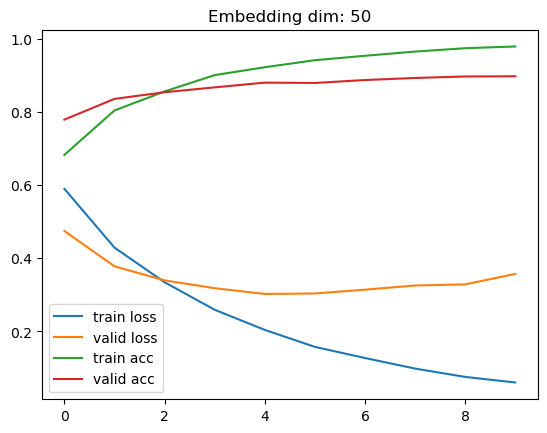

Test Loss: 0.301 | Test Acc: 88.54%
Epoch: 01 | Train Loss: 0.559 | Train Acc: 70.94% | Val. Loss: 0.425 | Val. Acc: 80.88%
Epoch: 02 | Train Loss: 0.383 | Train Acc: 83.01% | Val. Loss: 0.346 | Val. Acc: 84.53%
Epoch: 03 | Train Loss: 0.282 | Train Acc: 88.56% | Val. Loss: 0.305 | Val. Acc: 86.98%
Epoch: 04 | Train Loss: 0.208 | Train Acc: 91.96% | Val. Loss: 0.286 | Val. Acc: 88.31%
Epoch: 05 | Train Loss: 0.142 | Train Acc: 94.71% | Val. Loss: 0.304 | Val. Acc: 88.65%
Epoch: 06 | Train Loss: 0.101 | Train Acc: 96.41% | Val. Loss: 0.313 | Val. Acc: 88.98%
Epoch: 07 | Train Loss: 0.076 | Train Acc: 97.36% | Val. Loss: 0.305 | Val. Acc: 89.65%
Epoch: 08 | Train Loss: 0.057 | Train Acc: 98.11% | Val. Loss: 0.331 | Val. Acc: 89.58%
Epoch: 09 | Train Loss: 0.042 | Train Acc: 98.61% | Val. Loss: 0.342 | Val. Acc: 89.95%
Epoch: 10 | Train Loss: 0.038 | Train Acc: 98.87% | Val. Loss: 0.358 | Val. Acc: 90.25%


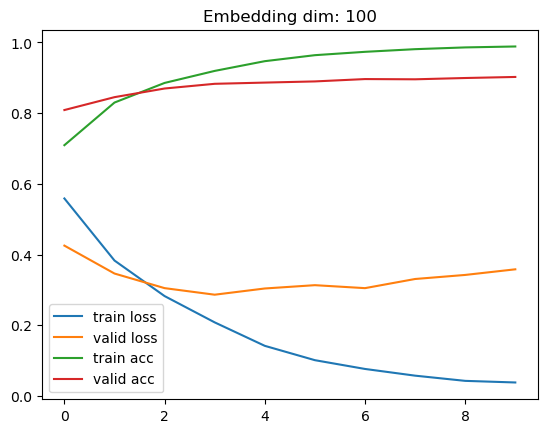

Test Loss: 0.301 | Test Acc: 87.89%
Epoch: 01 | Train Loss: 0.545 | Train Acc: 72.19% | Val. Loss: 0.396 | Val. Acc: 82.90%
Epoch: 02 | Train Loss: 0.356 | Train Acc: 84.55% | Val. Loss: 0.309 | Val. Acc: 87.64%
Epoch: 03 | Train Loss: 0.250 | Train Acc: 90.11% | Val. Loss: 0.275 | Val. Acc: 89.95%
Epoch: 04 | Train Loss: 0.166 | Train Acc: 93.78% | Val. Loss: 0.266 | Val. Acc: 89.77%
Epoch: 05 | Train Loss: 0.109 | Train Acc: 96.23% | Val. Loss: 0.295 | Val. Acc: 90.06%
Epoch: 06 | Train Loss: 0.077 | Train Acc: 97.32% | Val. Loss: 0.303 | Val. Acc: 89.79%
Epoch: 07 | Train Loss: 0.057 | Train Acc: 98.15% | Val. Loss: 0.341 | Val. Acc: 89.76%
Epoch: 08 | Train Loss: 0.043 | Train Acc: 98.57% | Val. Loss: 0.387 | Val. Acc: 89.59%
Epoch: 09 | Train Loss: 0.037 | Train Acc: 98.84% | Val. Loss: 0.400 | Val. Acc: 90.13%
Epoch: 10 | Train Loss: 0.032 | Train Acc: 99.13% | Val. Loss: 0.401 | Val. Acc: 89.93%


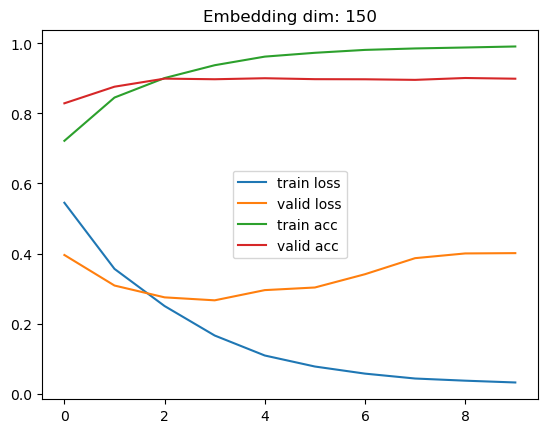

Test Loss: 0.266 | Test Acc: 90.02%


In [106]:
import matplotlib.pyplot as plt

# Define a list of embedding dimensions to loop over
embedding_dims = [50, 100, 150]

for embedding_dim in embedding_dims:
    # Create model with current embedding dimension
    input_dim = len(vocab)
    n_filters = 100
    filter_sizes = [3, 4, 5]
    output_dim = 1
    dropout = 0.5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, n_layers=0).to(device)

    # Train the model
    epochs = 10
    lr = 0.001
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{embedding_dim}.pt')

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    # Plot the training and validation losses and accuracies
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.plot(train_accs, label='train acc')
    plt.plot(valid_accs, label='valid acc')
    plt.title(f'Embedding dim: {embedding_dim}')
    plt.legend()
    plt.show()

    # Evaluate the model on the test set
    model.load_state_dict(torch.load(f'model_{embedding_dim}.pt'))
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


## 2.number of filters

Epoch: 01 | Train Loss: 0.580 | Train Acc: 69.11% | Val. Loss: 0.454 | Val. Acc: 79.59%
Epoch: 02 | Train Loss: 0.420 | Train Acc: 80.84% | Val. Loss: 0.365 | Val. Acc: 84.59%
Epoch: 03 | Train Loss: 0.309 | Train Acc: 87.04% | Val. Loss: 0.312 | Val. Acc: 87.11%
Epoch: 04 | Train Loss: 0.229 | Train Acc: 91.00% | Val. Loss: 0.281 | Val. Acc: 88.94%
Epoch: 05 | Train Loss: 0.175 | Train Acc: 93.51% | Val. Loss: 0.294 | Val. Acc: 89.25%
Epoch: 06 | Train Loss: 0.130 | Train Acc: 95.42% | Val. Loss: 0.290 | Val. Acc: 90.08%
Epoch: 07 | Train Loss: 0.095 | Train Acc: 96.63% | Val. Loss: 0.297 | Val. Acc: 90.23%
Epoch: 08 | Train Loss: 0.079 | Train Acc: 97.50% | Val. Loss: 0.313 | Val. Acc: 90.51%
Epoch: 09 | Train Loss: 0.062 | Train Acc: 97.97% | Val. Loss: 0.375 | Val. Acc: 90.03%
Epoch: 10 | Train Loss: 0.049 | Train Acc: 98.47% | Val. Loss: 0.378 | Val. Acc: 90.53%


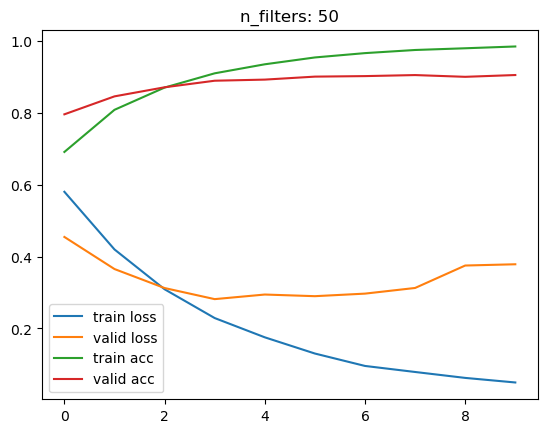

Test Loss: 0.292 | Test Acc: 88.50%
Epoch: 01 | Train Loss: 0.560 | Train Acc: 70.96% | Val. Loss: 0.444 | Val. Acc: 79.80%
Epoch: 02 | Train Loss: 0.379 | Train Acc: 83.08% | Val. Loss: 0.339 | Val. Acc: 85.66%
Epoch: 03 | Train Loss: 0.275 | Train Acc: 88.83% | Val. Loss: 0.311 | Val. Acc: 86.89%
Epoch: 04 | Train Loss: 0.194 | Train Acc: 92.97% | Val. Loss: 0.303 | Val. Acc: 88.02%
Epoch: 05 | Train Loss: 0.143 | Train Acc: 94.83% | Val. Loss: 0.278 | Val. Acc: 89.92%
Epoch: 06 | Train Loss: 0.103 | Train Acc: 96.35% | Val. Loss: 0.282 | Val. Acc: 90.04%
Epoch: 07 | Train Loss: 0.075 | Train Acc: 97.35% | Val. Loss: 0.291 | Val. Acc: 90.25%
Epoch: 08 | Train Loss: 0.054 | Train Acc: 98.22% | Val. Loss: 0.321 | Val. Acc: 90.65%
Epoch: 09 | Train Loss: 0.048 | Train Acc: 98.45% | Val. Loss: 0.330 | Val. Acc: 90.25%
Epoch: 10 | Train Loss: 0.038 | Train Acc: 98.82% | Val. Loss: 0.396 | Val. Acc: 90.06%


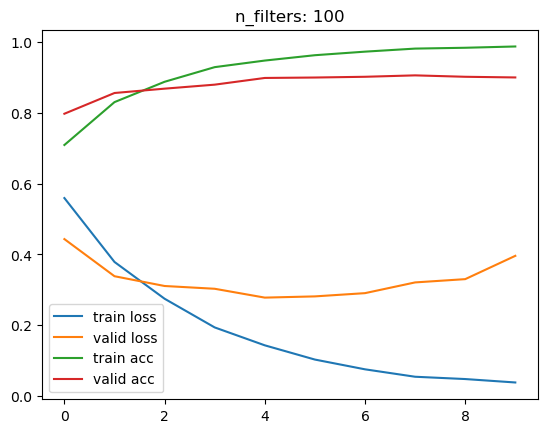

Test Loss: 0.284 | Test Acc: 89.77%
Epoch: 01 | Train Loss: 0.566 | Train Acc: 70.38% | Val. Loss: 0.419 | Val. Acc: 81.27%
Epoch: 02 | Train Loss: 0.391 | Train Acc: 82.61% | Val. Loss: 0.376 | Val. Acc: 82.56%
Epoch: 03 | Train Loss: 0.271 | Train Acc: 89.10% | Val. Loss: 0.297 | Val. Acc: 87.43%
Epoch: 04 | Train Loss: 0.189 | Train Acc: 92.98% | Val. Loss: 0.279 | Val. Acc: 89.04%
Epoch: 05 | Train Loss: 0.137 | Train Acc: 94.88% | Val. Loss: 0.281 | Val. Acc: 89.33%
Epoch: 06 | Train Loss: 0.091 | Train Acc: 96.78% | Val. Loss: 0.328 | Val. Acc: 89.42%
Epoch: 07 | Train Loss: 0.066 | Train Acc: 97.75% | Val. Loss: 0.345 | Val. Acc: 89.82%
Epoch: 08 | Train Loss: 0.050 | Train Acc: 98.30% | Val. Loss: 0.347 | Val. Acc: 89.95%
Epoch: 09 | Train Loss: 0.039 | Train Acc: 98.72% | Val. Loss: 0.352 | Val. Acc: 90.21%
Epoch: 10 | Train Loss: 0.034 | Train Acc: 98.91% | Val. Loss: 0.381 | Val. Acc: 90.18%


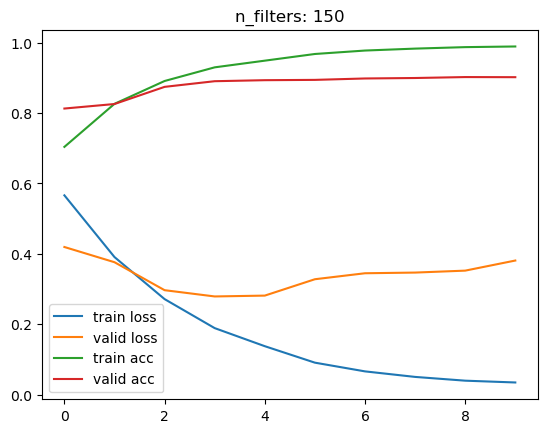

Test Loss: 0.271 | Test Acc: 89.62%


In [108]:
import matplotlib.pyplot as plt

# Define a list of n_filters values to loop over
n_filters_list = [50, 100, 150]

for n_filters in n_filters_list:
    # Create model with current n_filters value
    input_dim = len(vocab)
    embedding_dim = 100
    filter_sizes = [3, 4, 5]
    output_dim = 1
    dropout = 0.5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, n_layers=0).to(device)

    # Train the model
    epochs = 10
    lr = 0.001
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{n_filters}.pt')

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    # Plot the training and validation losses and accuracies
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.plot(train_accs, label='train acc')
    plt.plot(valid_accs, label='valid acc')
    plt.title(f'n_filters: {n_filters}')
    plt.legend()
    plt.show()

    # Evaluate the model on the test set
    model.load_state_dict(torch.load(f'model_{n_filters}.pt'))
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


## 3.dropout

Epoch: 01 | Train Loss: 0.531 | Train Acc: 72.83% | Val. Loss: 0.396 | Val. Acc: 83.01%
Epoch: 02 | Train Loss: 0.337 | Train Acc: 85.38% | Val. Loss: 0.316 | Val. Acc: 86.96%
Epoch: 03 | Train Loss: 0.219 | Train Acc: 91.66% | Val. Loss: 0.310 | Val. Acc: 87.22%
Epoch: 04 | Train Loss: 0.145 | Train Acc: 94.76% | Val. Loss: 0.265 | Val. Acc: 89.85%
Epoch: 05 | Train Loss: 0.096 | Train Acc: 96.83% | Val. Loss: 0.277 | Val. Acc: 90.16%
Epoch: 06 | Train Loss: 0.066 | Train Acc: 97.78% | Val. Loss: 0.291 | Val. Acc: 90.45%
Epoch: 07 | Train Loss: 0.047 | Train Acc: 98.49% | Val. Loss: 0.302 | Val. Acc: 90.68%
Epoch: 08 | Train Loss: 0.038 | Train Acc: 98.84% | Val. Loss: 0.320 | Val. Acc: 90.41%
Epoch: 09 | Train Loss: 0.030 | Train Acc: 99.14% | Val. Loss: 0.347 | Val. Acc: 90.12%
Epoch: 10 | Train Loss: 0.027 | Train Acc: 99.27% | Val. Loss: 0.368 | Val. Acc: 90.36%


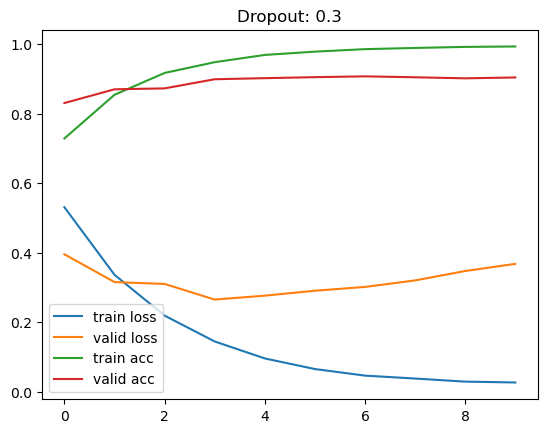

Test Loss: 0.299 | Test Acc: 88.87%
Epoch: 01 | Train Loss: 0.563 | Train Acc: 70.83% | Val. Loss: 0.419 | Val. Acc: 81.86%
Epoch: 02 | Train Loss: 0.383 | Train Acc: 82.97% | Val. Loss: 0.339 | Val. Acc: 86.11%
Epoch: 03 | Train Loss: 0.283 | Train Acc: 88.30% | Val. Loss: 0.297 | Val. Acc: 87.54%
Epoch: 04 | Train Loss: 0.200 | Train Acc: 92.30% | Val. Loss: 0.312 | Val. Acc: 87.36%
Epoch: 05 | Train Loss: 0.145 | Train Acc: 94.82% | Val. Loss: 0.271 | Val. Acc: 90.25%
Epoch: 06 | Train Loss: 0.098 | Train Acc: 96.45% | Val. Loss: 0.289 | Val. Acc: 90.10%
Epoch: 07 | Train Loss: 0.069 | Train Acc: 97.50% | Val. Loss: 0.344 | Val. Acc: 89.26%
Epoch: 08 | Train Loss: 0.058 | Train Acc: 98.13% | Val. Loss: 0.345 | Val. Acc: 89.86%
Epoch: 09 | Train Loss: 0.042 | Train Acc: 98.66% | Val. Loss: 0.364 | Val. Acc: 90.31%
Epoch: 10 | Train Loss: 0.034 | Train Acc: 98.84% | Val. Loss: 0.385 | Val. Acc: 90.41%


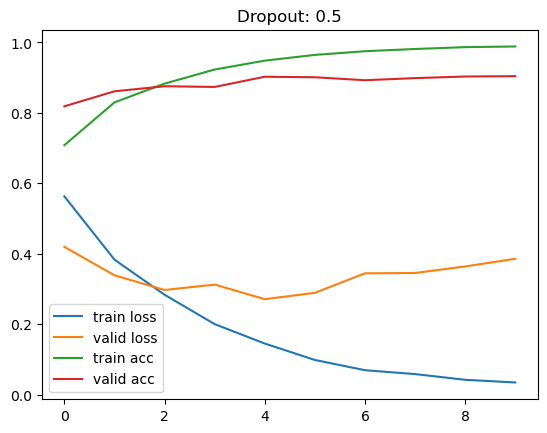

Test Loss: 0.269 | Test Acc: 90.39%
Epoch: 01 | Train Loss: 0.626 | Train Acc: 66.36% | Val. Loss: 0.486 | Val. Acc: 77.22%
Epoch: 02 | Train Loss: 0.460 | Train Acc: 78.32% | Val. Loss: 0.374 | Val. Acc: 83.79%
Epoch: 03 | Train Loss: 0.346 | Train Acc: 85.28% | Val. Loss: 0.327 | Val. Acc: 86.62%
Epoch: 04 | Train Loss: 0.267 | Train Acc: 89.16% | Val. Loss: 0.301 | Val. Acc: 88.00%
Epoch: 05 | Train Loss: 0.214 | Train Acc: 92.05% | Val. Loss: 0.285 | Val. Acc: 89.46%
Epoch: 06 | Train Loss: 0.166 | Train Acc: 93.97% | Val. Loss: 0.270 | Val. Acc: 90.09%
Epoch: 07 | Train Loss: 0.133 | Train Acc: 95.17% | Val. Loss: 0.289 | Val. Acc: 89.73%
Epoch: 08 | Train Loss: 0.109 | Train Acc: 96.40% | Val. Loss: 0.299 | Val. Acc: 90.46%
Epoch: 09 | Train Loss: 0.084 | Train Acc: 97.10% | Val. Loss: 0.326 | Val. Acc: 90.13%
Epoch: 10 | Train Loss: 0.069 | Train Acc: 97.72% | Val. Loss: 0.385 | Val. Acc: 89.99%


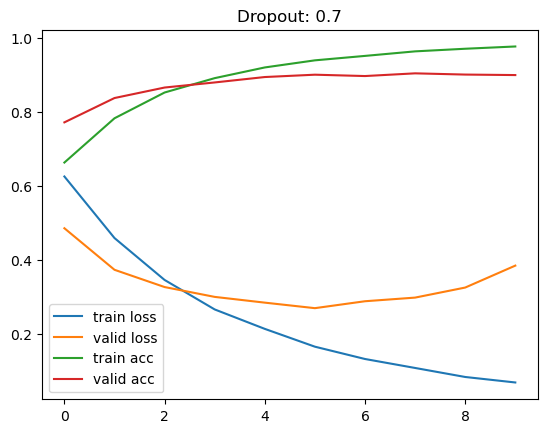

Test Loss: 0.268 | Test Acc: 90.48%


In [110]:
# Define a list of dropout values to loop over
dropout_vals = [0.3, 0.5, 0.7]

for dropout in dropout_vals:
    # Create model with current dropout value
    input_dim = len(vocab)
    embedding_dim = 100
    n_filters = 100
    filter_sizes = [3, 4, 5]
    output_dim = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, n_layers=0).to(device)

    # Train the model
    epochs = 10
    lr = 0.001
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{dropout}.pt')

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    # Plot the training and validation losses and accuracies
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.plot(train_accs, label='train acc')
    plt.plot(valid_accs, label='valid acc')
    plt.title(f'Dropout: {dropout}')
    plt.legend(loc='lower left')
    plt.show()

    # Evaluate the model on the test set
    model.load_state_dict(torch.load(f'model_{dropout}.pt'))
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## 4.learning rate

Epoch: 01 | Train Loss: 0.660 | Train Acc: 76.48% | Val. Loss: 0.363 | Val. Acc: 88.53%
Epoch: 02 | Train Loss: 0.352 | Train Acc: 90.30% | Val. Loss: 0.449 | Val. Acc: 89.00%
Epoch: 03 | Train Loss: 0.259 | Train Acc: 94.31% | Val. Loss: 0.475 | Val. Acc: 89.20%
Epoch: 04 | Train Loss: 0.213 | Train Acc: 95.76% | Val. Loss: 1.004 | Val. Acc: 89.73%
Epoch: 05 | Train Loss: 0.184 | Train Acc: 96.88% | Val. Loss: 1.101 | Val. Acc: 89.05%
Epoch: 06 | Train Loss: 0.239 | Train Acc: 96.76% | Val. Loss: 1.942 | Val. Acc: 88.00%
Epoch: 07 | Train Loss: 0.267 | Train Acc: 96.83% | Val. Loss: 2.063 | Val. Acc: 89.66%
Epoch: 08 | Train Loss: 0.303 | Train Acc: 97.17% | Val. Loss: 2.790 | Val. Acc: 88.92%
Epoch: 09 | Train Loss: 0.280 | Train Acc: 97.50% | Val. Loss: 3.422 | Val. Acc: 87.36%
Epoch: 10 | Train Loss: 0.275 | Train Acc: 97.75% | Val. Loss: 3.916 | Val. Acc: 89.16%


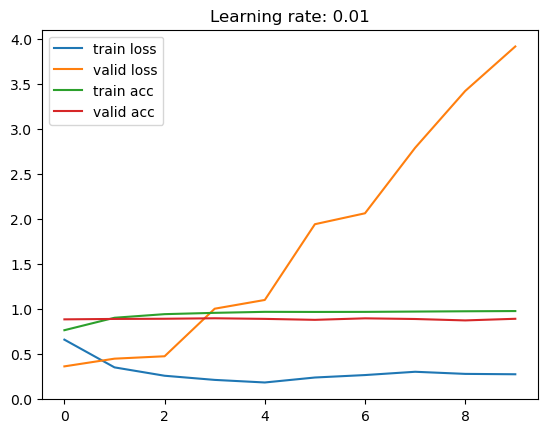

Test Loss: 0.367 | Test Acc: 88.80%
Epoch: 01 | Train Loss: 0.566 | Train Acc: 70.27% | Val. Loss: 0.428 | Val. Acc: 79.68%
Epoch: 02 | Train Loss: 0.385 | Train Acc: 82.81% | Val. Loss: 0.332 | Val. Acc: 85.14%
Epoch: 03 | Train Loss: 0.271 | Train Acc: 88.78% | Val. Loss: 0.287 | Val. Acc: 87.93%
Epoch: 04 | Train Loss: 0.193 | Train Acc: 92.64% | Val. Loss: 0.264 | Val. Acc: 89.41%
Epoch: 05 | Train Loss: 0.132 | Train Acc: 95.19% | Val. Loss: 0.268 | Val. Acc: 90.08%
Epoch: 06 | Train Loss: 0.098 | Train Acc: 96.43% | Val. Loss: 0.292 | Val. Acc: 90.61%
Epoch: 07 | Train Loss: 0.072 | Train Acc: 97.42% | Val. Loss: 0.309 | Val. Acc: 90.03%
Epoch: 08 | Train Loss: 0.055 | Train Acc: 98.13% | Val. Loss: 0.318 | Val. Acc: 90.21%
Epoch: 09 | Train Loss: 0.043 | Train Acc: 98.62% | Val. Loss: 0.352 | Val. Acc: 90.62%
Epoch: 10 | Train Loss: 0.035 | Train Acc: 98.91% | Val. Loss: 0.376 | Val. Acc: 90.89%


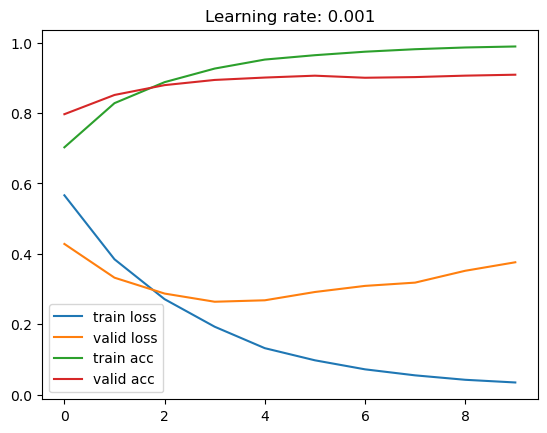

Test Loss: 0.277 | Test Acc: 89.01%
Epoch: 01 | Train Loss: 0.662 | Train Acc: 61.44% | Val. Loss: 0.590 | Val. Acc: 69.65%
Epoch: 02 | Train Loss: 0.610 | Train Acc: 67.24% | Val. Loss: 0.565 | Val. Acc: 72.91%
Epoch: 03 | Train Loss: 0.570 | Train Acc: 70.52% | Val. Loss: 0.540 | Val. Acc: 73.20%
Epoch: 04 | Train Loss: 0.533 | Train Acc: 73.84% | Val. Loss: 0.511 | Val. Acc: 75.48%
Epoch: 05 | Train Loss: 0.500 | Train Acc: 75.67% | Val. Loss: 0.486 | Val. Acc: 78.06%
Epoch: 06 | Train Loss: 0.466 | Train Acc: 78.09% | Val. Loss: 0.463 | Val. Acc: 78.99%
Epoch: 07 | Train Loss: 0.442 | Train Acc: 79.90% | Val. Loss: 0.447 | Val. Acc: 78.98%
Epoch: 08 | Train Loss: 0.408 | Train Acc: 82.09% | Val. Loss: 0.425 | Val. Acc: 80.43%
Epoch: 09 | Train Loss: 0.384 | Train Acc: 82.97% | Val. Loss: 0.409 | Val. Acc: 81.93%
Epoch: 10 | Train Loss: 0.364 | Train Acc: 84.17% | Val. Loss: 0.395 | Val. Acc: 82.46%


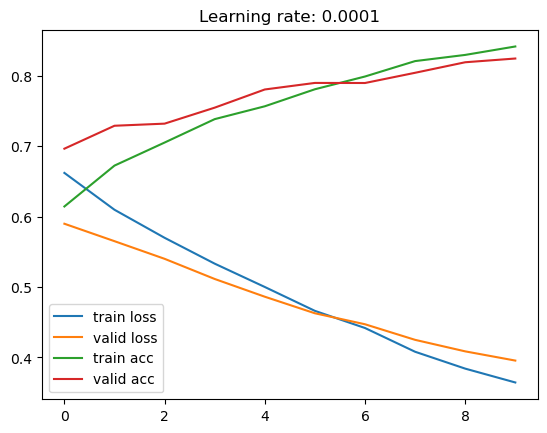

Test Loss: 0.399 | Test Acc: 82.45%


In [111]:
# Define a list of learning rates to loop over
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    # Create model with current learning rate
    input_dim = len(vocab)
    embedding_dim = 100
    n_filters = 100
    filter_sizes = [3, 4, 5]
    output_dim = 1
    dropout = 0.5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, n_layers=0).to(device)

    # Train the model
    epochs = 10
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{lr}.pt')

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    # Plot the training and validation losses and accuracies
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.plot(train_accs, label='train acc')
    plt.plot(valid_accs, label='valid acc')
    plt.title(f'Learning rate: {lr}')
    plt.legend()
    plt.show()

    # Evaluate the model on the test set
    model.load_state_dict(torch.load(f'model_{lr}.pt'))
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')